# Методы восстановления регрессии

Задачу обучения по прецедентам при $Y=\mathbb{R}$ принято называть задачей восстановления регрессии. Задано пространство объектов X и множество возможных ответов Y. Существует неизвестная целевая зависимость $y^*:X\rightarrow Y$ , значения которой известны только на объектах обучающей выборки $X^\ell = (x_i, y_i)_{i-1}^\ell, y_i = y^* (x_i)$. Требуется построить алгоритм, который в данной задаче принято называть "функцией регрессии" $a: X^* \rightarrow Y$ , аппроксимирующий целевую зависимость $y^*$.

 ## Непараметрическая регрессия: ядерное сглаживание
 
 Для начала установим внешние зависимости:

In [42]:
import numpy as np
import math
import matplotlib.pyplot as plot

%matplotlib inline

Обучающую выборку сгенирируем сами на основе функции синуса, и добавим к нему шум, чтобы данные были более "реалистичными".
Возьмем синус от $-2\Pi$ до $4\Pi$, размер выборки 100, шум 0.2.

In [35]:
import regression.datasets as datasets

size = 100
data = datasets.sin_with_noise(-2 * np.pi, 4 * np.pi, size, noise=0.3)
xl, yl = data['xl'], data['yl']

Получили следующую выборку:

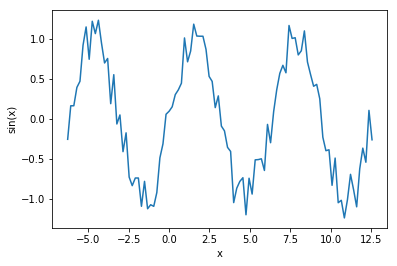

In [36]:
plot.plot(xl, yl)
plot.xlabel('x')
plot.ylabel('sin(x)')
plot.show()

### Формула Надарая–Ватсона
Возьмём самую простую модель регрессии, какая только возможна – константу $g(x, \alpha) = \alpha, \alpha \in \mathbb{R}$. Но при этом, чтобы не получить тривиального решения, введём веса объектов $w_i(x)$, зависящие от того объекта $x$, в котором мы собираемся вычислять значение $a(x) = g(x, \alpha)$. Можно сказать и так, что обучение регрессионной модели будет производиться отдельно в каждой точке $x$ пространства объектов $X$.

Зададим веса $w_i$ обучающих объектов так, чтобы они убывали по мере увеличения расстояния $\rho(x, x_i)$. Для этого введём невозрастающую, гладкую, ограниченную функцию $K$, называемую ядром.
Для непараметрической регрессии обычно используют 2 типа ядер: **гаусовское** и **квартическое**. Наша задача их сравнить.

In [37]:
def gauss(r):
    return (2 * math.pi) ** -0.5 * math.exp(-0.5 * r ** 2)

def quartic(r):
    return 15/16 * (1 - r ** 2) ** 2 * _sign(math.fabs(r) <= 1)

def _sign(condition):
    return 1 if condition else 0

Для вычисления предполагаемого ответа алгоритма в точке $x$ применим формулу Надарая-Ватсона:

In [38]:
from regression.utils import distance

def nw_regression(x, xl, yl, h, kernel):
    top, bottom = 0, 0
    for i, x_i in enumerate(xl):
        k = kernel(distance(x, x_i) / h)
        top += yl[i] * k
        bottom += k

    return float('inf') if bottom == 0 else top / bottom

Для определения оптимальной ширины окна _h_ нужно подобрать параметр с помощью *метода наименьших квадратов*

In [39]:
def loo(xl, yl, hl, kernel):
    h_errors = []

    for h in hl:
        h_error = 0
        for i, x in enumerate(xl):
            y_r = nw_regression(x, np.delete(xl, i), np.delete(yl, i), h, kernel)
            h_error += (y_r - yl[i]) ** 2
        h_errors.append(h_error)

    return h_errors

Для тестирования показателей алгоритма при разных ядрах подготовим функцию:
1. Создаем массив предполагаемых значений окон *h* от 0.1 до 1 с шагом 0.05. Пропускаем их через _LOO_, чтобы выбрать окно с наименьшей ошибкой. Ошибки выводим для дальнейшего анализа.
2. Для наилучшего окна вычисляем значения регрессии.
3. Выводим результат

In [40]:
def test_by_kernel(kernel):
    # 1
    hl = np.arange(0.1, 1, 0.05)
    h_errors = loo(xl, yl, hl, kernel)
    print('H errors', h_errors)
    
    # 2
    min_i = np.argmin(h_errors)
    h_error = round(h_errors[min_i], 5)
    best_h = round(hl[min_i], 1)
    yl_r = list(map(lambda x: nw_regression(x, xl, yl, best_h, kernel), xl))
    
    # 3
    plot.plot(xl, yl)
    plot.plot(xl, yl_r)
    plot.xlabel('x, h = ' + str(best_h))
    plot.ylabel('sin(x), mistake = ' + str(h_error))
    plot.show()

Протестируем и сравним 2 ядра.
1. **Гауссовское ядро**

H errors [5.8801927880031, 5.460907579052738, 4.891644881308201, 4.558281545916089, 4.425215318232097, 4.434559069899496, 4.559465152602867, 4.787810880377826, 5.113568472061488, 5.533414967022802, 6.045166663661645, 6.646989765367, 7.3369910326945, 8.112981037085797, 8.972311211692253, 9.911750964855, 10.927399720565544, 12.014636174654749]


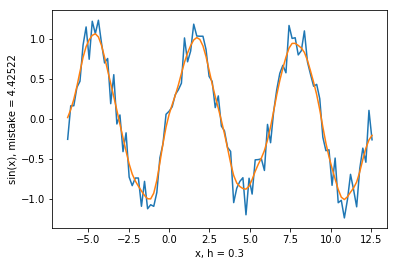

In [43]:
test_by_kernel(gauss)

2. **Квартическое ядро**

H errors [inf, inf, 5.905013323814352, 5.905013323814349, 5.905013323814352, 5.9050133238143525, 5.8227594990018865, 5.341621820350477, 4.9558447595522335, 4.7144425565852845, 4.559112554536972, 4.451694106563536, 4.3882305072783065, 4.3553460966844835, 4.340427764414296, 4.339944755134327, 4.353666068142953, 4.377744937658035]


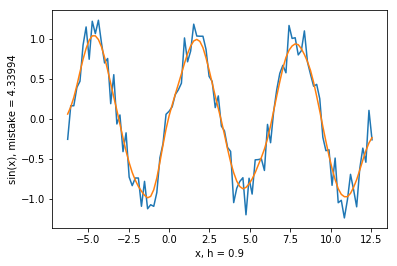

In [44]:
test_by_kernel(quartic)

Как показали тесты, ядра на качество регрессии при правильно подобранной ширине окна почти не влияют. Однако, у каждого ядра оптимальная ширина окна своя. И за счет того, что гаусовское ядро бесконечное, оно сильно теряет в качестве при увеличении ширины окна, в отличие от квартического.